__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/python3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

6619


,title,adr,latitude,longitude,priceM,ts
6603,Участок 16 сот. (ИЖС),"Севастополь,ул. Горпищенко",44.58,33.58,12.80,2022-09-19 12:39:53.571
2734,Участок 5 сот. (ИЖС),"Севастополь,ул. Адмирала Де Воллана",44.578267,33.533813,1.55,2022-09-13 13:56:54.600
403,Участок 5 сот. (ИЖС),"Севастополь,пр. Генерала Мельника",44.58,33.56,1.90,2022-09-08 16:04:40.227


In [6]:
# df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None

In [7]:
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619 entries, 0 to 6618
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   avito_id            6619 non-null   int64         
 1   title               6619 non-null   object        
 2   price               6619 non-null   int64         
 3   obj_name            6619 non-null   object        
 4   adr_orig            6619 non-null   object        
 5   description         6619 non-null   object        
 6   avito_page          6619 non-null   int64         
 7   ts                  6619 non-null   datetime64[ns]
 8   place               6619 non-null   object        
 9   area                6619 non-null   float64       
 10  is_IJS              6619 non-null   bool          
 11  priceM              6619 non-null   float64       
 12  priceMU             6619 non-null   float64       
 13  area_size_category  6619 non-null   category    

In [9]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
1320,Участок 4 сот. (ИЖС),"Севастополь,ул. Второй Обороны, 2",44.57069,33.572396,4.00,2022-09-12 13:51:16.745
4095,Участок 4 сот. (ИЖС),"Севастополь,с. Штурмовое, ул. Коминтерна",44.57,33.62,2.50,2022-09-15 10:31:26.039
3226,Участок 5 сот. (ИЖС),"Севастополь,Фёдоровская ул.",44.67,33.55,2.50,2022-09-13 13:56:54.600


In [10]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

6619
6612


### ограничиваем тип объекта 

In [11]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
6321,Участок 8 сот. (ИЖС),"Севастополь,с. Угловое",44.820669,33.606675,2.10
1295,Участок 10 сот. (ИЖС),"Севастополь,Нахимовский район , Любимовка",44.66,33.54,2.80
5118,"Участок 6,2 сот. (ИЖС)","Севастополь,Фортификационная ул., 134/51",44.499459,33.620321,3.70


In [13]:
del df

In [14]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика изменение цены

In [15]:
ts = '2022-08-01' # ограничиваем дату

In [16]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean   std  min  10%   25%   50%   75%  \
area_size_category dt                                                          
<1                 2022-09-08   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-12   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-13   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-15   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-16   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-19   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
1-2                2022-09-08   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-12   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-13   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-15   3.00  1.77  0.06 1.70 1.72  1.75  1.80  1.80   
                   2022-09-16   3.00  1.77  0.06 1.70 1.72  1.75  1.80  1.80   
                   2022-09-19   2.00  1.80  0.00 1.80 1.80  1.80  1.80  1.80   
2-4                2022-09-08 143.00  3.46  1.87 1.15 1.59  2.05  2.85  4.38   
                   2022-09-12 144.00  3.61  2.34 1.15 1.61  2.17  2.88  4.50   
                   2022-09-13 149.00  3.57  2.29 1.15 1.60  2.10  2.99  4.50   
                   2022-09-15 152.00  3.59  2.28 1.15 1.70  2.19  2.92  4.50   
                   2022-09-16 148.00  3.60  2.26 1.15 1.70  2.20  3.00  4.50   
                   2022-09-19 147.00  3.51  2.26 1.15 1.65  2.10  2.75  4.50   
4-8                2022-09-08 518.00  4.52  3.41 1.10 1.90  2.50  3.50  5.20   
                   2022-09-12 550.00  4.55  4.02 1.10 1.90  2.50  3.50  5.20   
                   2022-09-13 553.00  4.48  3.99 1.10 1.86  2.50  3.40  5.10   
                   2022-09-15 550.00  4.43  3.86 1.10 1.85  2.45  3.45  5.07   
                   2022-09-16 541.00  4.49  4.17 1.10 1.85  2.45  3.35  5.20   
                   2022-09-19 544.00  4.41  3.86 1.10 1.85  2.40  3.40  5.20   
8-20               2022-09-08 348.00  6.40  6.57 1.10 2.00  3.00  4.60  7.41   
                   2022-09-12 343.00  6.28  6.19 1.10 2.00  3.00  4.60  7.00   
                   2022-09-13 344.00  6.37  6.24 1.10 2.00  3.00  4.60  7.03   
                   2022-09-15 349.00  6.40  6.28 1.10 2.00  3.00  4.50  7.00   
                   2022-09-16 344.00  6.39  6.25 1.10 2.00  3.00  4.50  7.00   
                   2022-09-19 345.00  6.42  6.47 1.10 2.00  2.90  4.50  7.00   
20+                2022-09-08  34.00 33.26 30.40 1.10 5.40 14.00 23.50 37.75   
                   2022-09-12  35.00 31.53 30.52 1.10 3.54 11.00 21.00 37.50   
                   2022-09-13  35.00 33.32 31.20 1.10 4.80 12.75 21.00 44.00   
                   2022-09-15  40.00 31.43 33.43 1.10 2.99  8.30 17.25 37.25   
                   2022-09-16  37.00 33.52 33.91 2.10 5.70 10.00 19.00 38.00   
                   2022-09-19  41.00 32.67 33.05 2.10 3.00  8.30 19.00 40.00   

                                90%    max  
area_size_category dt                       
<1                 2022-09-08 13.61  15.00  
                   2022-09-12 13.61  15.00  
                   2022-09-13 13.61  15.00  
                   2022-09-15 13.61  15.00  
                   2022-09-16 13.61  15.00  
                   2022-09-19 13.61  15.00  
1-2                2022-09-08  1.88   1.90  
                   2022-09-12  1.88   1.90  
                   2022-09-13  1.88   1.90  
                   2022-09-15  1.80   1.80  
                   2022-09-16  1.80   1.80  
                   2022-09-19  1.80   1.80  
2-4                2022-09-08  6.00  11.70  
                   2022-09-12  6.14  20.00  
                   2022-09-13  6.00  20.00  
                   2022-09-15  5.98  20.00  
                   2022-09-16  5.80  20.00  
                   2022-09-19  5.80  20.00  
4-8                2022-09-08  8.13  29.00  
                   2022-09-12  8.00  60.00  


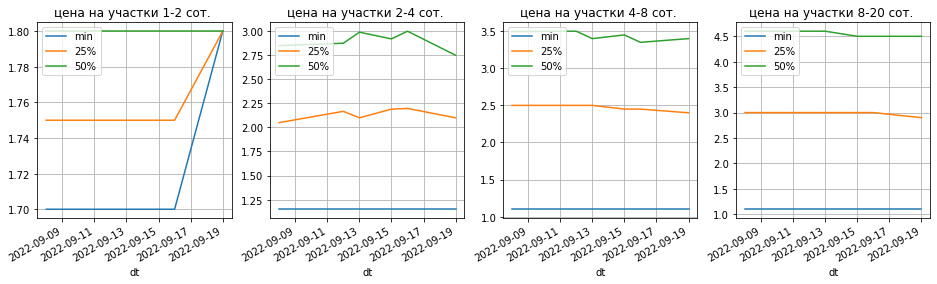

In [17]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '1-2', '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
for i,s in enumerate(sizes): 
    stat.loc[s,['min','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### район поиска

In [18]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

### гексагональная сетка

In [19]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [20]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
7,862d2d49fffffff,"POLYGON ((33.70175 44.71197, 33.68026 44.68260, 33.70713 44.65381, 33.75546 44.65437, 33.77696 44.68373, 33.75012 44.71254, 33.70175 44.71197))"
12,862d28977ffffff,"POLYGON ((33.42254 44.59175, 33.40116 44.56227, 33.42811 44.53349, 33.47643 44.53419, 33.49782 44.56366, 33.47089 44.59244, 33.42254 44.59175))"


### медиана актуальной цены

In [21]:
# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [22]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [23]:
frames.explore('area_name')

In [24]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

6612
230


In [25]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[gdf_['ts']>ts][cols].explore( 'area_size_category',legend=True)

### изменение цены

In [26]:
stat = (
    gdf_.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count   mean  std    min    10%    25%    50%  \
area_size_category dt                                                          
2-4                2022-09-08   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-12   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-13   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-15   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-16   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
                   2022-09-19   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
4-8                2022-09-08  22.00   3.75 2.17   1.60   2.00   2.23   2.75   
                   2022-09-12  25.00   3.48 1.89   1.45   1.80   2.20   2.80   
                   2022-09-13  24.00   3.27 1.61   1.45   1.80   2.20   2.75   
                   2022-09-15  25.00   3.21 1.61   1.45   1.80   2.20   2.70   
                   2022-09-16  24.00   3.30 1.67   1.45   1.80   2.15   2.75   
                   2022-09-19  24.00   3.35 1.67   1.45   1.80   2.15   2.90   
8-20               2022-09-08   9.00   6.02 5.10   1.65   2.33   3.10   4.25   
                   2022-09-12   8.00   6.21 4.71   1.65   2.67   3.18   4.53   
                   2022-09-13   9.00   6.43 4.45   1.65   2.81   3.20   4.80   
                   2022-09-15  10.00   5.44 4.46   1.65   2.10   2.72   3.73   
                   2022-09-16   9.00   5.76 4.61   1.65   2.05   3.10   4.25   
                   2022-09-19   9.00   5.76 4.61   1.65   2.05   3.10   4.25   
20+                2022-09-08   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-12   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-13   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-15   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-16   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-19   1.00 120.00  NaN 120.00 120.00 120.00 120.00   

                                 75%    90%    max  
area_size_category dt                               
2-4                2022-09-08   2.95   3.40   3.70  
                   2022-09-12   2.95   3.40   3.70  
                   2022-09-13   2.95   3.40   3.70  
                   2022-09-15   2.95   3.40   3.70  
                   2022-09-16   2.70   3.30   3.70  
                   2022-09-19   2.70   3.30   3.70  
4-8                2022-09-08   4.78   7.86   8.50  
                   2022-09-12   4.50   5.88   8.50  
                   2022-09-13   3.97   4.80   8.00  
                   2022-09-15   3.80   4.80   8.00  
                   2022-09-16   4.50   4.94   8.00  
                   2022-09-19   4.50   4.94   8.00  
8-20               2022-09-08   5.80  12.92  17.00  
                   2022-09-12   7.33  12.83  15.00  
                   2022-09-13   8.20  12.52  15.00  
                   2022-09-15   5.55  12.21  15.00  
                   2022-09-16   5.80  12.52  15.00  
                   2022-09-19   5.80  12.52  15.00  
20+                2022-09-08 120.00 120.00 120.00  
                   2022-09-12 120.00 120.00 120.00  
                   2022-09-13 120.00 120.00 120.00  
                   2022-09-15 120.00 120.00 120.00  
                   2022-09-16 120.00 120.00 120.00  
                   2022-09-19 120.00 120.00 120.00

In [27]:
gdf_['area_size_category'].unique()

['8-20', '4-8', '2-4', '20+']
Categories (6, object): ['<1' < '1-2' < '2-4' < '4-8' < '8-20' < '20+']

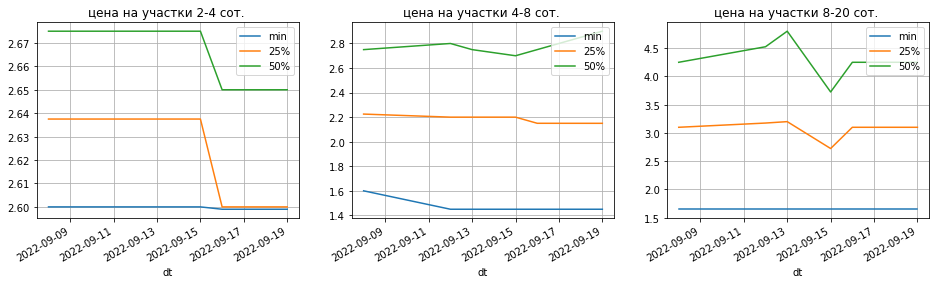

In [28]:
import matplotlib.pyplot as plt

# sizes = gdf_['area_size_category'].unique()
# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
for i,s in enumerate(sizes): 
    stat.loc[s,['min','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### гексагональная сетка

In [29]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
6,892d2894233ffff,"POLYGON ((33.53494 44.57845, 33.53461 44.57667, 33.53670 44.57550, 33.53910 44.57613, 33.53943 44.57792, 33.53734 44.57908, 33.53494 44.57845))"
31,892d28943dbffff,"POLYGON ((33.53591 44.58382, 33.53558 44.58203, 33.53767 44.58087, 33.54008 44.58150, 33.54040 44.58329, 33.53832 44.58445, 33.53591 44.58382))"


### медиана актуальной цены

In [30]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [31]:
# gdf[['latitude','longitude']].max()

# min
# latitude    43.23
# longitude   33.40

# max
# latitude    44.90
# longitude   34.19

In [32]:
# from shapely.geometry import Point

# gpd.GeoDataFrame(
#     {'pos':['min','max']},
#     geometry=gpd.points_from_xy( [33.40,34.19], [43.23,44.90]),
#     crs='epsg:4326',
# ).explore()